# **CarAvalia**

***

## Grupo

Leonardo Henrique Bernardes de Souza | 1091392223034

Samuel Luiz Martins dos Santos       | 1091392223033

## Descrição do Domínio

**CarAvalia** é um aplicativo inteligente que ajuda os usuários a decidir se vale a pena comprar um determinado veículo. Com base nas informações fornecidas pelo usuário que indentificam o véiculo, o CarAvalia analisa uma variedade de fatores, como preço, custos de manutenção, quantidade de portas, tamanho de porta-malas e espaço para passageiros. O aplicativo gera uma avaliação personalizada, auxiliando o usuário a fazer uma escolha informada e segura na hora de adquirir seu veículo.

## Link da base

https://archive.ics.uci.edu/dataset/19/car+evaluation

## Características do Conjunto de Dados

Nome: Car Evaluation Database

Descrição: Derivado de um modelo hierárquico simples de decisão, este banco de dados pode ser útil para testar métodos de indução construtiva e descoberta de estrutura.

Tipo: Multivariado

Tarefas Associadas: Classificação

Tipo de Atributo: Categórico

Número de Instâncias: 1728

Número de Atributos: 6

> [!NOTE]
> O dataset não possui dados faltantes.
<br/>

O Car Evaluation Database foi derivado de um modelo hierárquico simples de decisão desenvolvido originalmente para a demonstração do DEX, conforme descrito no trabalho de M. Bohanec e V. Rajkovic: "Expert system for decision making," publicado na Sistemica 1(1), pp. 145-157, 1990. Omodelo avalia carros de acordo com a seguinte estrutura de conceitos:

- CAR:Aceitabilidade do carro
  -  PRICE: Preço geral
    - buying: Preço de compra. Categorizado como:
      - vhigh (muito alto);
      - high(alto);
      - med(médio);
      - low(baixo).
    - maint: Custo de manutenção. Categorizado como:
      - vhigh (muito alto);
      - high(alto);
      - med(médio);
      - low(baixo).
  - TECH:Características técnicas
    - COMFORT:Conforto
      - doors: Número de portas. Categorizado como:
        - 2;
        - 3;
        - 4;
        - 5more(5oumais).
      - persons: Capacidade de pessoas. Categorizado como:
        - 2;
        - 4;
        - more(mais).
      - lug_boot: Tamanho do porta-malas. Categorizado como:
        - small (pequeno);
        - med(médio);
        - big(grande).
    - safety: Segurança estimada do carro. Categorizado como:
        - low;
        - med;
        - high.
  
Os Rótulos de Classe são escritos da seguinte maneira:

- unacc: Inaceitável
- acc: Aceitável
- good:Bom
- vgood: Muito bom

Os atributos de entrada estão escritos em minúsculas. Além do conceito alvo (CAR), o modelo inclui três conceitos intermediários: PRICE, TECH, e COMFORT. Cada conceito no modelo original está relacionado aos seus descendentes de nível inferior por um conjunto de exemplos. O Car Evaluation Database contém exemplos com a informação estrutural removida, ou seja, relaciona diretamente CAR aos seis atributos de entrada: buying, maint, doors, persons, lug_boot, safety.

Para uma visualização mais clara da estrura dos dados, imagine a seguinte tabela:

|     | buying | maint | doors | persons | lug_boot | safety | class |
|-----|--------|-------|-------|---------|----------|--------|-------|
| Car | vhigh  | vhigh |   2   |    2    |  small   |   low  | unacc |

> [!NOTE]
> Baseado no arquivo [car.arff](./data/car.arff)
> ```
> @relation car
>
> @attribute buying {vhigh,high,med,low}
> @attribute maint {vhigh,high,med,low}
> @attribute doors {2,3,4,5more}
> @attribute persons {2,4,more}
> @attribute lug_boot {small,med,big}
> @attribute safety {low,med,high}
> @attribute class {unacc,acc,good,vgood}
>
> @data
> vhigh,vhigh,2,2,small,low,unacc
> ```


## Importando e Carregando Dados

In [ ]:
# Importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import arff
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Carregando o dataset .arff
data = arff.loadarff('../data/car.arff')
# Convertendo para DataFrame
df = pd.DataFrame(data[0])

# Remover o prefixo b' das strings
df = df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Exibindo as primeiras linhas do DataFrame
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Análise Inicial

In [4]:
# Verificando as informações do DataFrame
print("\nInformações do DataFrame:\n")
df.info()

print("\nDimensão: ")
print(df.shape)

# Resumo estatístico
df_detalhes = df.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB

Dimensão: 
(1728, 7)

Estatísticas do DataFrame:


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


### Distribuição das classes

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

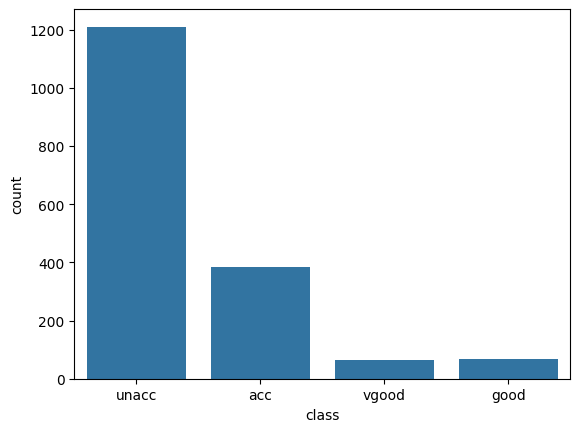

In [5]:
display(df['class'].value_counts())

# cria um gráfico de barras com a frequência de cada classe
sns.countplot(x="class", data=df)

# mostra o gráfico
plt.show()

### Visualização em gráfico da distribuição de atributos

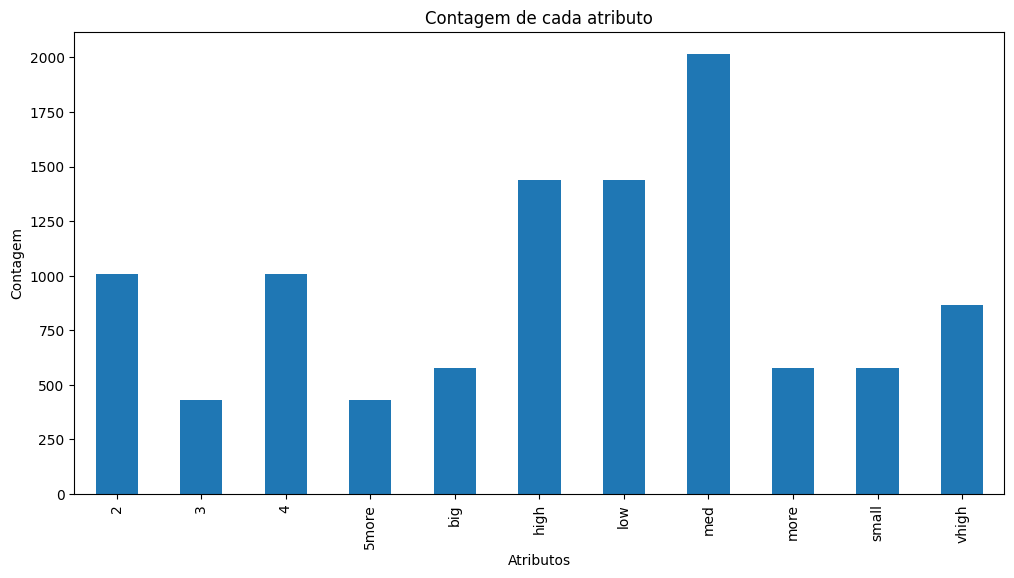

In [6]:
# Contar a frequência de cada categoria em cada coluna (exceto 'class')
counts = df.drop(columns=['class']).apply(pd.Series.value_counts).fillna(0)

# Somar as contagens de cada atributo
sums = counts.sum(axis=1)

# Plotar os resultados
sums.plot(kind='bar', figsize=(12, 6))
plt.title('Contagem de cada atributo')
plt.xlabel('Atributos')
plt.ylabel('Contagem')
plt.show()


### Importância dos atributos


Importância dos Atributos:

1. Atributo safety_low: 0.1408
2. Atributo persons_2: 0.1322
3. Atributo safety_high: 0.0749
4. Atributo safety_med: 0.0601
5. Atributo persons_4: 0.0563
6. Atributo maint_vhigh: 0.0511
7. Atributo lug_boot_small: 0.0476
8. Atributo buying_low: 0.0463
9. Atributo buying_vhigh: 0.0451
10. Atributo persons_more: 0.0414
11. Atributo buying_high: 0.0389
12. Atributo maint_low: 0.0380
13. Atributo buying_med: 0.0364
14. Atributo maint_high: 0.0356
15. Atributo lug_boot_big: 0.0334
16. Atributo maint_med: 0.0321
17. Atributo doors_2: 0.0291
18. Atributo lug_boot_med: 0.0201
19. Atributo doors_3: 0.0140
20. Atributo doors_4: 0.0136
21. Atributo doors_5more: 0.0132

***



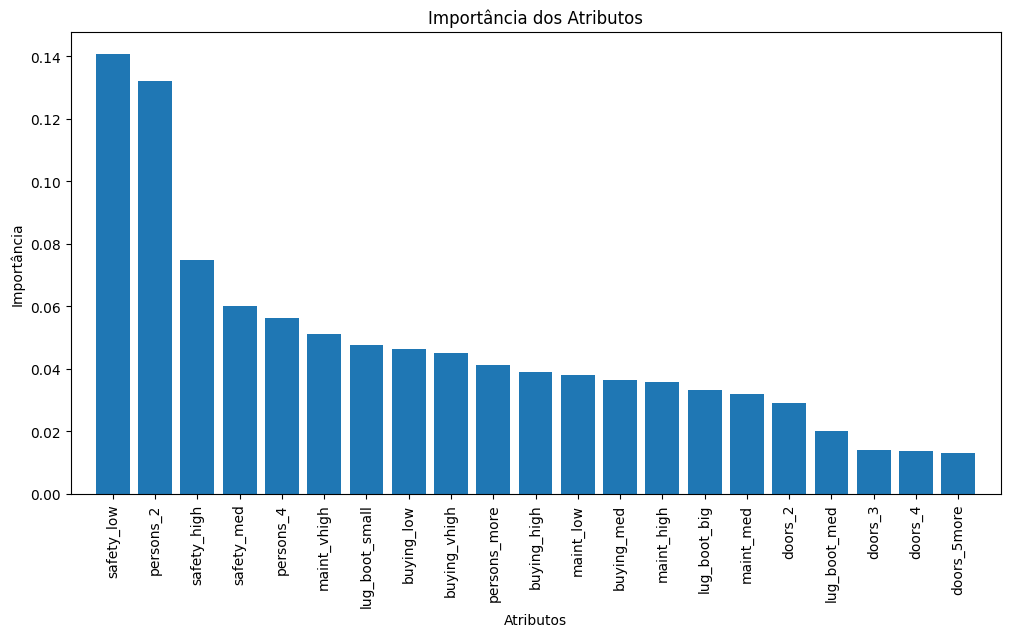

In [7]:
# Codificar as variáveis categóricas
X = pd.get_dummies(df.drop('class', axis=1))
y = df['class']

# Criar e treinar o modelo
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Ordenar as importâncias dos atributos
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nImportância dos Atributos:\n")

# Imprimir a importância dos atributos
for f in range(X.shape[1]):
    print(f"{f + 1}. Atributo {X.columns[indices[f]]}: {importances[indices[f]]:.4f}")

print("\n***\n")

# Configurar o gráfico
plt.figure(figsize=(12, 6))
plt.title("Importância dos Atributos")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)  # Rótulos dos atributos
plt.xlim([-1, X.shape[1]])
plt.xlabel("Atributos")
plt.ylabel("Importância")
plt.show()

### Matriz de correlação

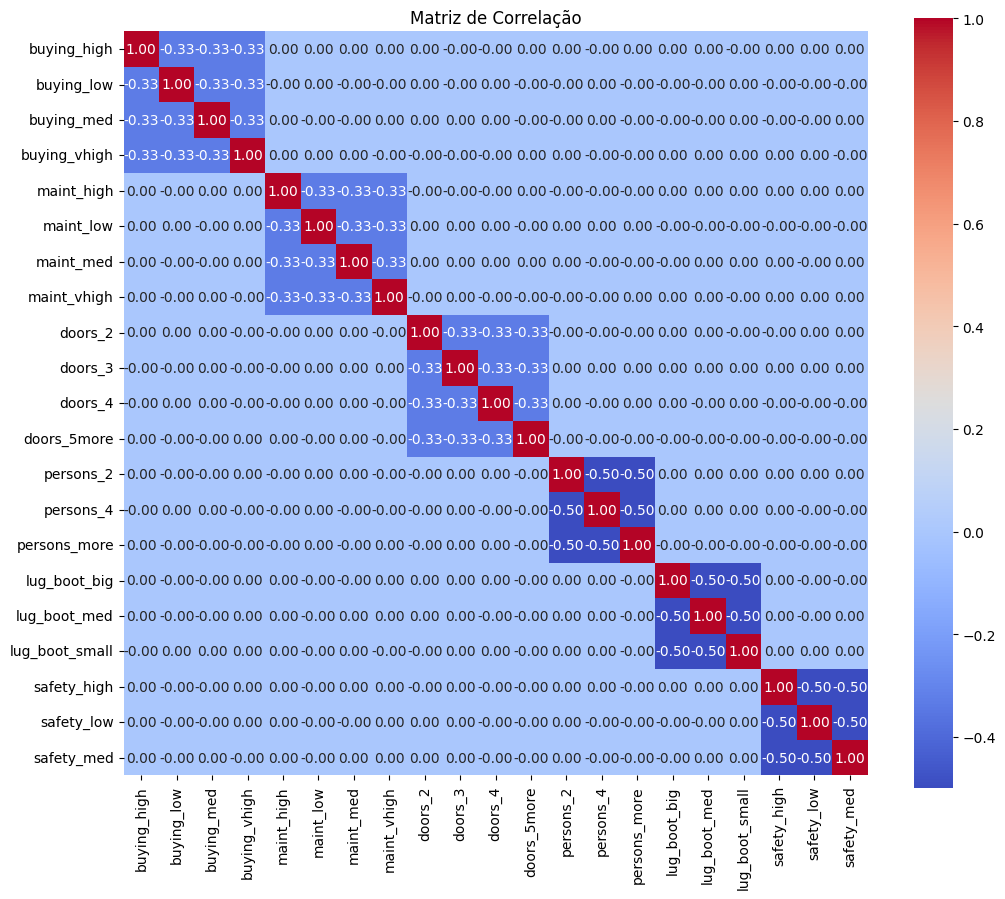

In [8]:
# Remover a coluna de classes
df_numeric = pd.get_dummies(df.drop(columns=['class']))

# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlação')
plt.show()

### Análise das proporções

#### **Proporção das classes**

A distribuição das classes apresenta a seguinte configuração:

- **Inaceitável (unacc)**: 70.02%
- **Aceitável (acc)**: 22.22%
- **Bom (good)**: 3.99%
- **Muito Bom (vgood)**: 3.76%

A classe "**Inaceitável**" é claramente a mais prevalente, o que sugere um desequilíbrio significativo no dataset. Esse desequilíbrio pode afetar o desempenho do modelo, tornando-o tendencioso em favor da classe majoritária. Medidas de balanceamento, como SMOTE e undersampling, são essenciais para mitigar esse problema e melhorar a generalização do modelo.

<br/>

#### **Proporções dos atributos categóricos**

A análise das proporções dos atributos indica que a maioria das características (compras, manutenção, portas, capacidade, tamanho do porta-malas e segurança) apresenta uma distribuição relativamente uniforme entre seus valores. Por exemplo:

- Atributo "buying":

    - "High" (1) representa 25% dos dados, enquanto "Low", "Medium" e "Very High" também têm 25% cada.

- Atributo "maint":

    - A mesma distribuição se repete para "maint", indicando que as escolhas de manutenção não influenciam significativamente a classe.

- Atributo "doors":

    - A distribuição entre os atributos de portas é igualmente uniforme, com cada valor contribuindo de forma semelhante para o total.

- Atributos de Capacidade e Tamanho do Porta-Malas:

    - A proporção de "persons" e "lug_boot" mostra uma leve tendência em direção a valores mais baixos, mas ainda mantém uma distribuição balanceada.

- Atributo "safety":

    - A segurança é um fator crítico, e a distribuição mostra que os atributos de segurança também seguem um padrão semelhante.

Porém, com relação a importância dos atributos, podemos notar que a preferencia está em uma segurança baixa e na capacidade de duas pessoas.

<br/>

### Considerações finais

A predominância da classe "Inaceitável" destaca a importância de aplicar técnicas de balanceamento. Além disso, as distribuições uniformes entre os atributos sugerem que eles podem contribuir igualmente para a predição. Essa informação pode ser utilizada para ajustar as abordagens de modelagem, otimizando a seleção de características e as estratégias de amostragem.

Apesar de utilizarmos técnicas para uma uniformização leve dos dados de atributos, nosso foco será na mitigação da discrepancia entre as classes.

## Pré-Processamento

### Eliminação de atributos irrelevantes

Felizmente o dataset não possui atributos irrelevantes, mas caso houvese, poderiamos tratá-lo da seguinte maneira:

```python
# remove as colunas user_id e original_city
df = df.drop(columns=['user_id','original_city'])

# imprime o dataframe
display(df.head(n=10))
```

### Tratamento de atributos com valores ausentes

Felizmente não há campos nulos em nosso dataset.

In [9]:
# índices das linhas que contém valores NaN
idxRowNan = pd.isnull(df).any(axis=1).to_numpy().nonzero()

# imprime apenas as linhas com valoes ausentes
display(df.iloc[idxRowNan])

,buying,maint,doors,persons,lug_boot,safety,class


In [10]:
def trataFaltantes(df):
    '''
    Normalmente substituiria os valores faltantes pela média dos outros valores do mesmo atributo de amostras que
    fosse da mesma classe, mas como como os seus dados dessa base são categóricos, será substituido os valores
    faltantes pela moda dos outros valores do mesmo atributo de amostras que sejam da mesma classe.
    '''

    # Cria um dicionário para armazenar as modas de cada classe para cada coluna
    modas = {}

    # Para cada coluna, calcula a moda de cada classe
    for column in df.columns:
        modas[column] = df.groupby('class')[column].agg(lambda x: x.mode()[0])

    # Verifica se há valores nulos em cada coluna e substitui
    for column in df.columns:
        if df[column].isnull().any():
            # Substitui os valores nulos pela moda correspondente à classe
            df[column].fillna(modas[column][df['class']], inplace=True)

    return df

# Supondo que você tivesse valores nulos em meu DataFrame, chamariamos a função
df = trataFaltantes(df)

# Para verificar quais linhas continham valores nulos antes da substituição, executariamos:
idxRowNan = df[df.isnull().any(axis=1)].index
print('\nAmostras que tinham valores faltantes:')
display(df.iloc[idxRowNan])


Amostras que tinham valores faltantes:


,buying,maint,doors,persons,lug_boot,safety,class


### Tratamento de dados inconsistentes ou redundantes

Felizmente não há valores redundantes ou inconsistentes em nosso dataset.

In [11]:
def delDuplicatas(df):
    '''
    Para cada grupo de amostras duplicadas, mantém uma e apaga as demais.
    '''
    df = df.drop_duplicates(keep='first')
    return df

# Detectar duplicatas
df_duplicates = df[df.duplicated(keep=False)]

# Se houver valores redundantes, imprima
if len(df_duplicates) > 0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')

# Remover duplicatas
df = delDuplicatas(df)
print("\nDataFrame após remoção de duplicatas:")
display(df)

Não existem valores duplicados

DataFrame após remoção de duplicatas:


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [12]:
# Para detectar inconsistências
def delInconsistencias(df):
    '''
    Remove todas as amostras inconsistentes da base de dados.
    '''
    df = df.drop_duplicates(subset=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], keep=False)
    return df

# Obtém as amostras onde os valores dos atributos estão duplicados
df_duplicates_inconsistentes = df[df.duplicated(subset=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], keep=False)]

# Se houver inconsistências, imprima
if len(df_duplicates_inconsistentes) > 0:
    print('\nAmostras inconsistentes:')
    display(df_duplicates_inconsistentes)
else:
    print('Não existem amostras inconsistentes')

# Remover inconsistências
df = delInconsistencias(df)
print("\nDataFrame após remoção de inconsistências:")
display(df)

Não existem amostras inconsistentes

DataFrame após remoção de inconsistências:


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [13]:
# Vamos revisar as estatísticas da base de dados
df_detalhes = df.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Estatísticas do DataFrame:


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


### Normalização dos atributos

A normalização é útil quando você tem atributos numéricos contínuos que podem variar amplamente. Essa técnica é utilizada para trazer esses dados para uma escala semelhante, mas como estamos lidando principalmente com atributos categóricos, a representação binária (0 e 1) faz mais sentido. Essa abordagem captura a presença ou ausência de características de forma clara e é apropriada para a análise e a modelagem.

Mesmo que tenhamos atributos como "número de portas" ou "número de passageiros", representá-los como categorias pode ser mais adequado no contexto de nosso dataset, especialmente por eles não serem contínuos.

Por isso utilizaremos o **one-hot encoding**, uma técnica aplicada a dados categóricos para transformar cada categoria em uma nova coluna binária, onde ``1`` indica a presença da categoria e ``0`` a ausência.

In [14]:
# Aplicando one-hot encoding
df_encoded = pd.get_dummies(df, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], drop_first=False)

# Convertendo valores booleanos para inteiros
numeric_columns = df_encoded.select_dtypes(include=[bool]).columns  # Seleciona colunas booleanas
df_encoded[numeric_columns] = df_encoded[numeric_columns].astype(int)  # Converte para inteiros

print(df_encoded.head())


   class  buying_high  buying_low  buying_med  buying_vhigh  maint_high  \
0  unacc            0           0           0             1           0   
1  unacc            0           0           0             1           0   
2  unacc            0           0           0             1           0   
3  unacc            0           0           0             1           0   
4  unacc            0           0           0             1           0   

   maint_low  maint_med  maint_vhigh  doors_2  ...  doors_5more  persons_2  \
0          0          0            1        1  ...            0          1   
1          0          0            1        1  ...            0          1   
2          0          0            1        1  ...            0          1   
3          0          0            1        1  ...            0          1   
4          0          0            1        1  ...            0          1   

   persons_4  persons_more  lug_boot_big  lug_boot_med  lug_boot_small  \
0     

Em outro contexto, se fosse necessário normalizar atributos em valores numéricos. poderiamos por exemplo o seguinte script:

```python
def normalizar(X):
    m, n = X.shape  # m = qtde de objetos e n = qtde de atributos por objeto
    X_norm = np.zeros((m, n))  # inicializa X_norm com zeros
    mu = np.mean(X, axis=0)  # calcula a média
    sigma = np.std(X, axis=0, ddof=1)  # calcula o desvio padrão

    for i in range(m):
        X_norm[i, :] = (X[i, :] - mu) / sigma

    return X_norm, mu, sigma

# Identificando colunas numéricas
numeric_columns = df_encoded.select_dtypes(include=[np.number]).columns.tolist()  # Seleciona colunas numéricas
X = df_encoded[numeric_columns].values  # Seleciona os valores para normalização

# Chama a função para normalizar X
X_norm, mu, sigma = normalizar(X)

# Atualiza o DataFrame com os valores normalizados
df_encoded[numeric_columns] = X_norm
```

In [15]:
# Verificando as informações do DataFrame
print("\nInformações do DataFrame:\n")
df_encoded.info()

print("\n")

# Resumo estatístico
df_detalhes = df_encoded.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           1728 non-null   object
 1   buying_high     1728 non-null   int64 
 2   buying_low      1728 non-null   int64 
 3   buying_med      1728 non-null   int64 
 4   buying_vhigh    1728 non-null   int64 
 5   maint_high      1728 non-null   int64 
 6   maint_low       1728 non-null   int64 
 7   maint_med       1728 non-null   int64 
 8   maint_vhigh     1728 non-null   int64 
 9   doors_2         1728 non-null   int64 
 10  doors_3         1728 non-null   int64 
 11  doors_4         1728 non-null   int64 
 12  doors_5more     1728 non-null   int64 
 13  persons_2       1728 non-null   int64 
 14  persons_4       1728 non-null   int64 
 15  persons_more    1728 non-null   int64 
 16  lug_boot_big    1728 non-null   int64 
 17  lug_boot_med    1728 non

,class,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
count,1728,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,...,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
unique,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,unacc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
std,NaN,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,0.433138,...,0.433138,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541,0.471541
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Detecção de *Outliers*

> [!NOTE]
> Após essa conversão dos atributos em um formato binário, podemos produzir mais alguns gráficos que nos trarão mais insights das discrepâncias do dataset e continuar a normalização para chegarmos na quantidade e qualidade de dados ideal.

#### Gráfico de box and whisker

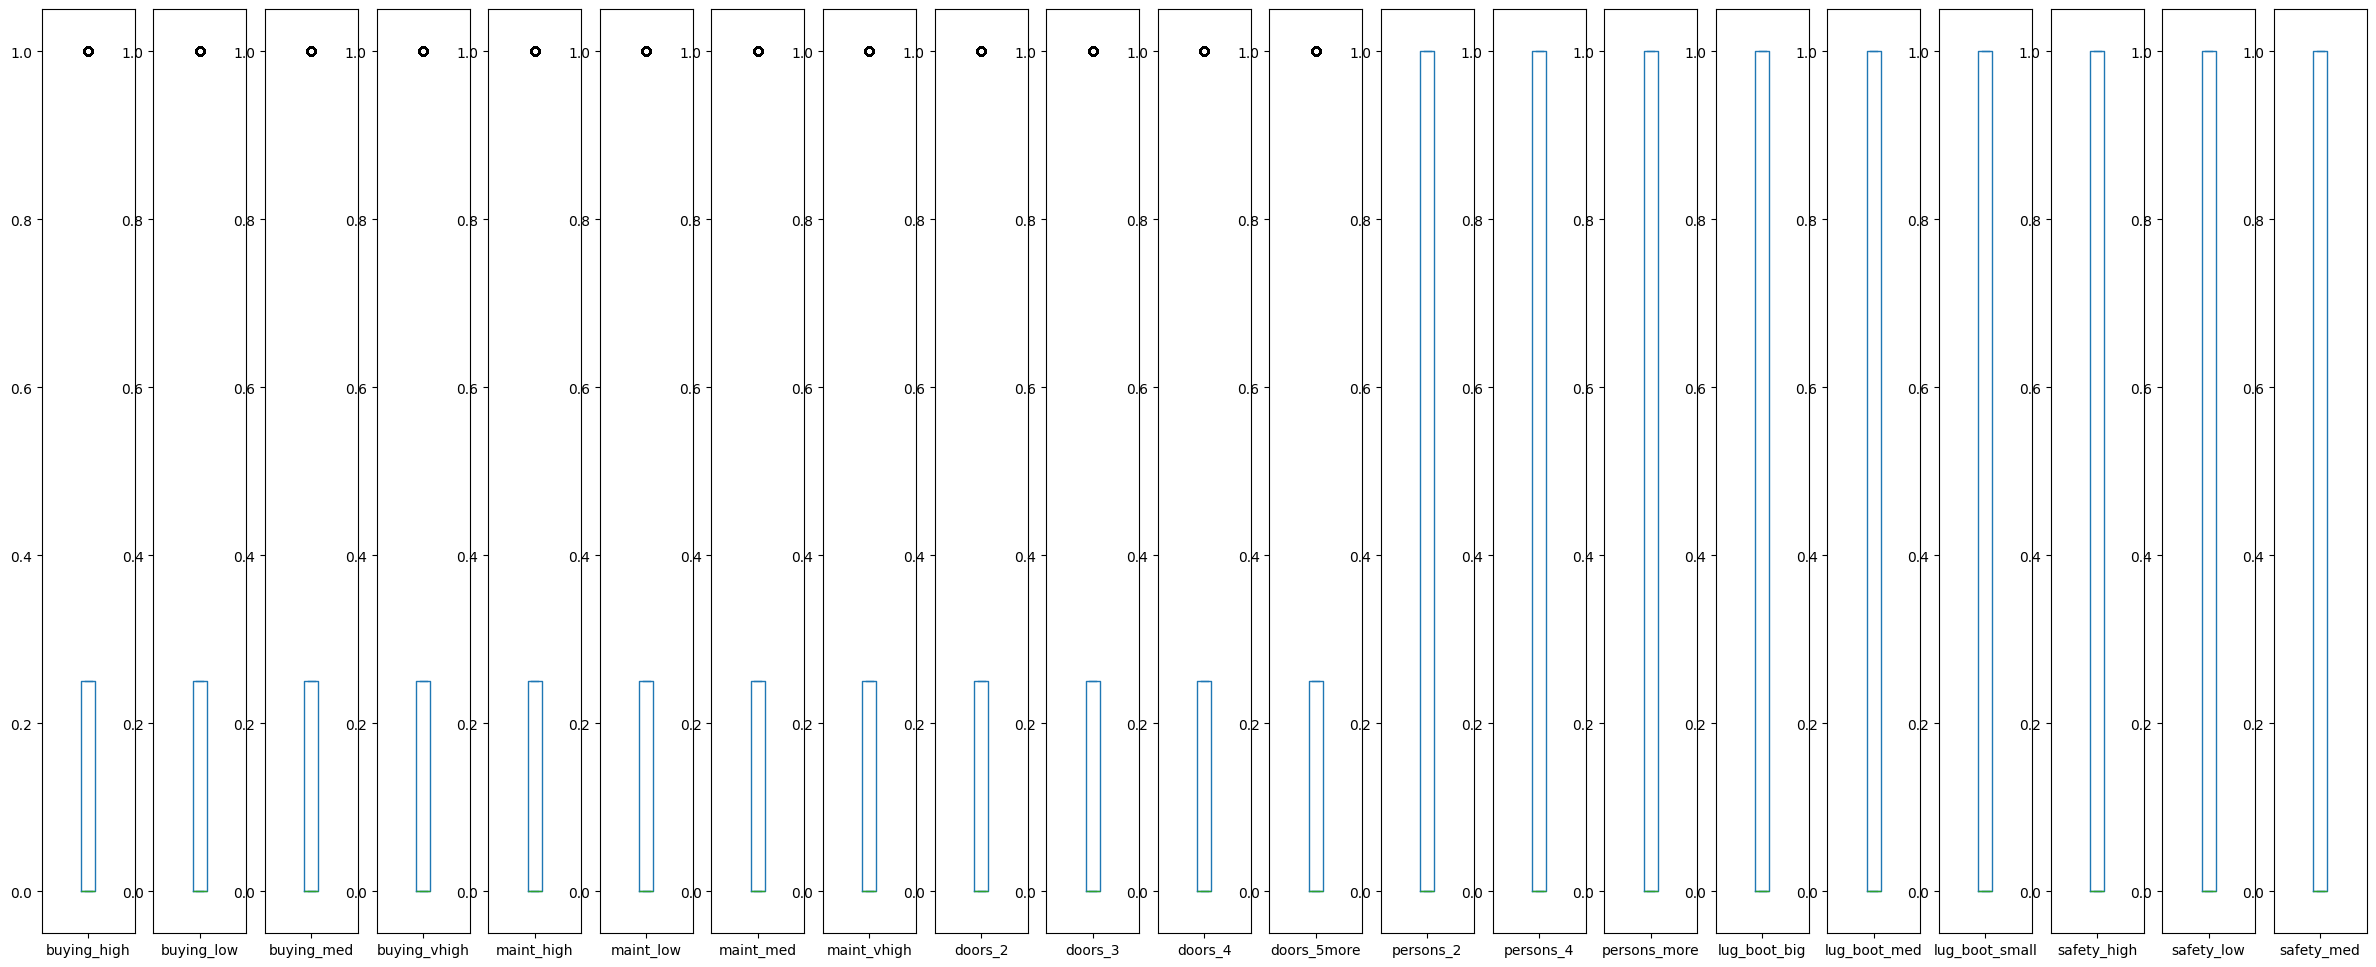

In [16]:
df_without_class = df_encoded.drop(columns=['class'])

df_without_class.plot(kind='box', subplots=True, layout=(21,21), figsize=(30, 300), sharex=False, sharey=False)
plt.show()

#### Histograma

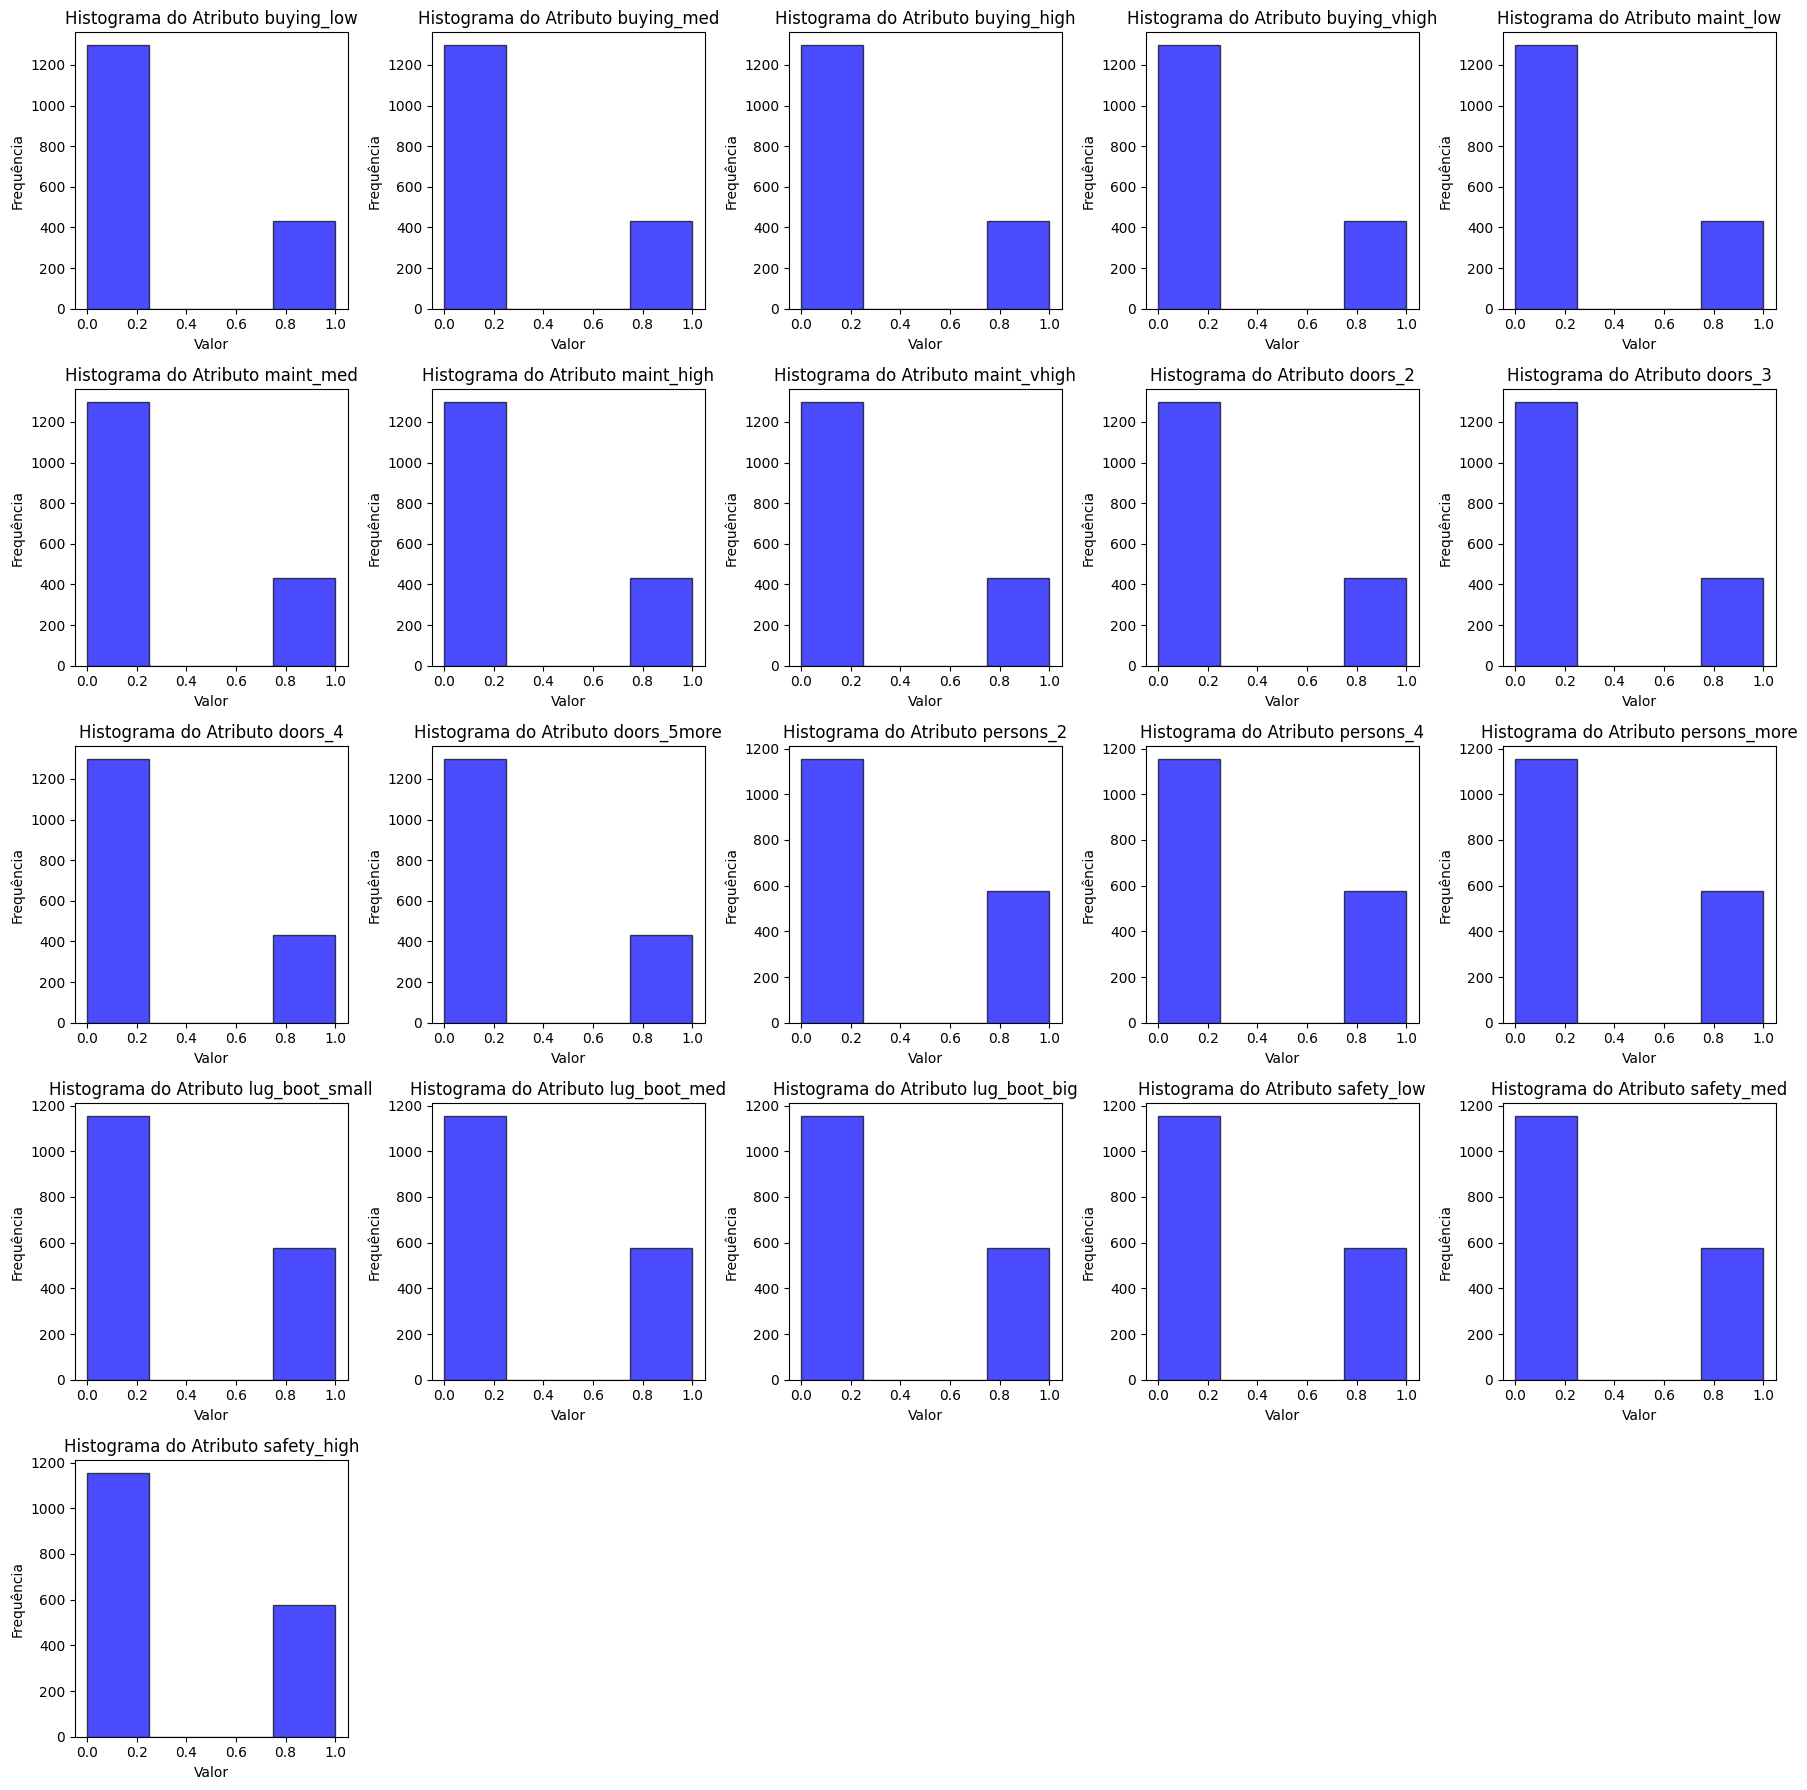

In [17]:
# Selecionando os atributos para visualização
attributes = [
    'buying_low', 'buying_med', 'buying_high', 'buying_vhigh',
    'maint_low', 'maint_med', 'maint_high', 'maint_vhigh',
    'doors_2', 'doors_3', 'doors_4', 'doors_5more',
    'persons_2', 'persons_4', 'persons_more',
    'lug_boot_small', 'lug_boot_med', 'lug_boot_big',
    'safety_low', 'safety_med', 'safety_high'
]

# Configurando o tamanho da figura
plt.figure(figsize=(18, 18))

# Loop para criar histogramas para cada atributo
for i, attr in enumerate(attributes, start=1):
    plt.subplot(5, 5, i)  # Organiza os subgráficos em uma grade
    plt.hist(df_encoded[attr], bins=4, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histograma do Atributo {attr}')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')

plt.tight_layout()  # Ajusta os subgráficos para evitar sobreposição
plt.show()

#### Matriz de Dispersão

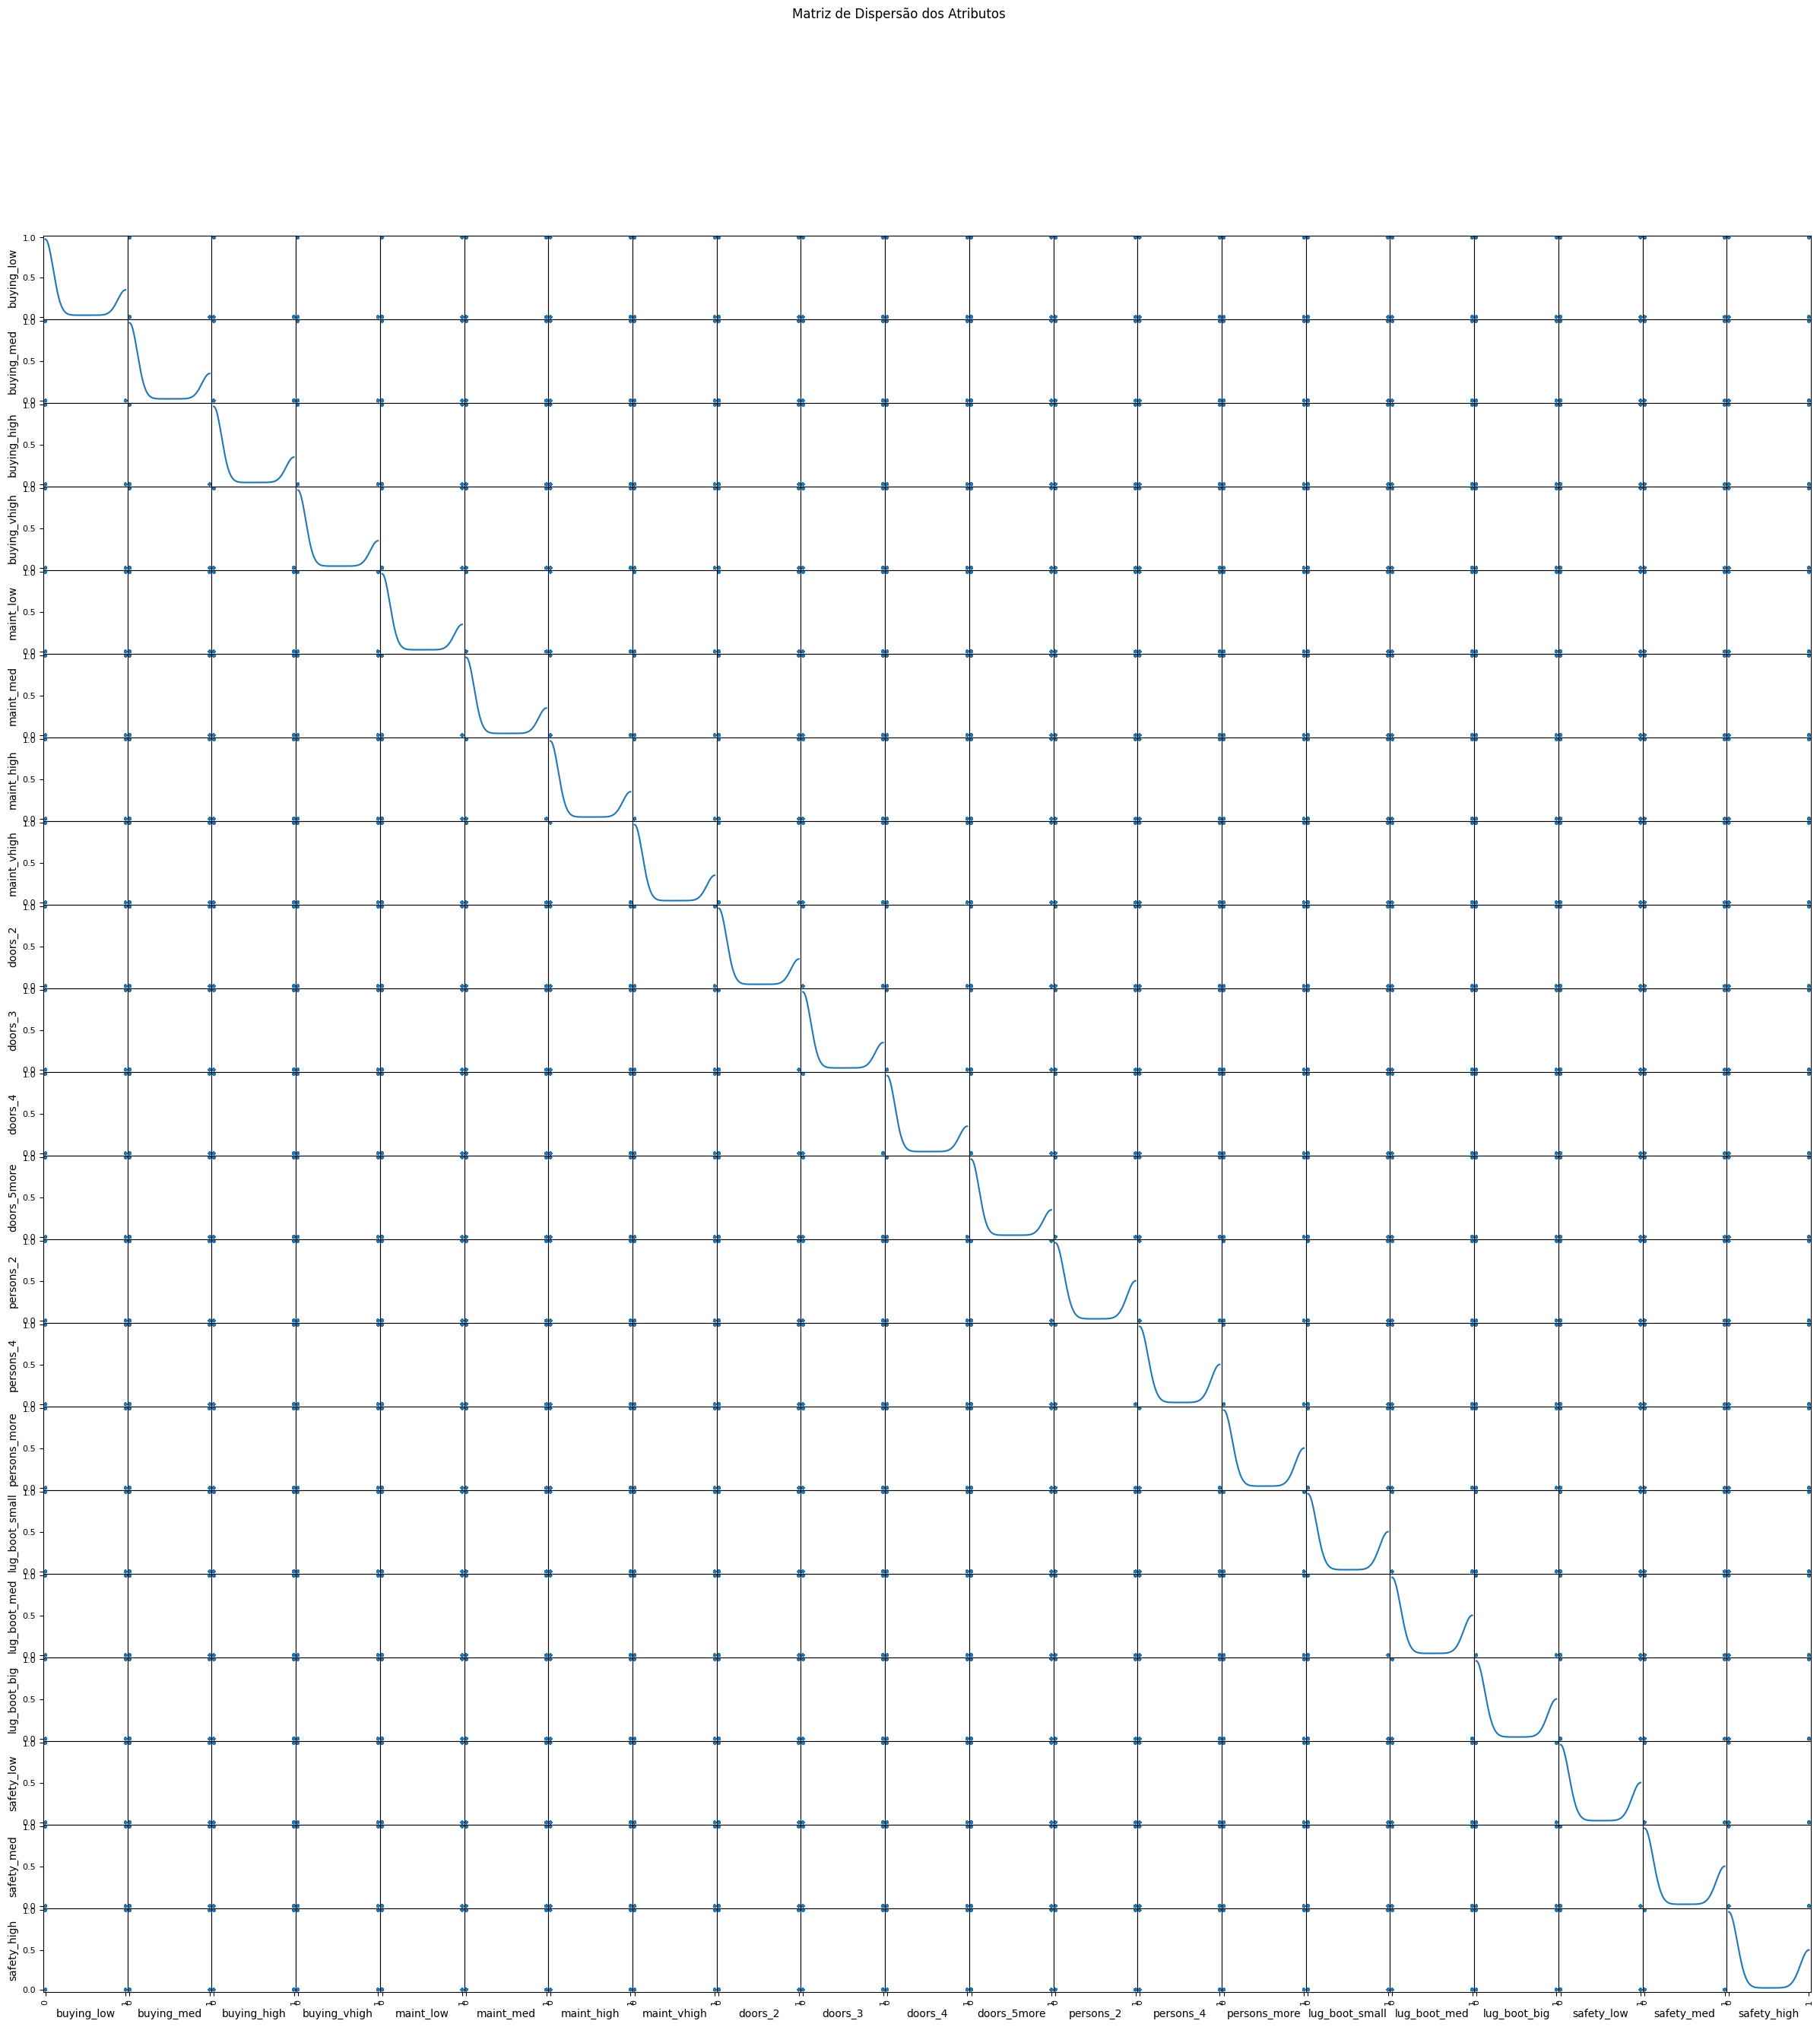

In [18]:
# Selecionando os atributos para a matriz de dispersão
attributes = [
    'buying_low', 'buying_med', 'buying_high', 'buying_vhigh',
    'maint_low', 'maint_med', 'maint_high', 'maint_vhigh',
    'doors_2', 'doors_3', 'doors_4', 'doors_5more',
    'persons_2', 'persons_4', 'persons_more',
    'lug_boot_small', 'lug_boot_med', 'lug_boot_big',
    'safety_low', 'safety_med', 'safety_high'
]

# Criando a matriz de dispersão
scatter_matrix(df_encoded[attributes], figsize=(30, 30), diagonal='kde', alpha=0.5)

plt.suptitle('Matriz de Dispersão dos Atributos')
plt.show()

Se algum atributo tiver uma proporção extremamente desequilibrada, pode ser um indicativo de outliers.

Por exemplo, se um atributo tem 90% de 0s e 10% de 1s, e você espera um balanceamento mais próximo de 50/50, isso pode ser considerado anômalo.

class:
class
unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: proportion, dtype: float64

buying_high:
buying_high
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_low:
buying_low
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_med:
buying_med
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_vhigh:
buying_vhigh
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_high:
maint_high
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_low:
maint_low
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_med:
maint_med
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_vhigh:
maint_vhigh
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_2:
doors_2
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_3:
doors_3
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_4:
doors_4
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_5more:
doors_5more
0    0.75
1    0.25
Nam

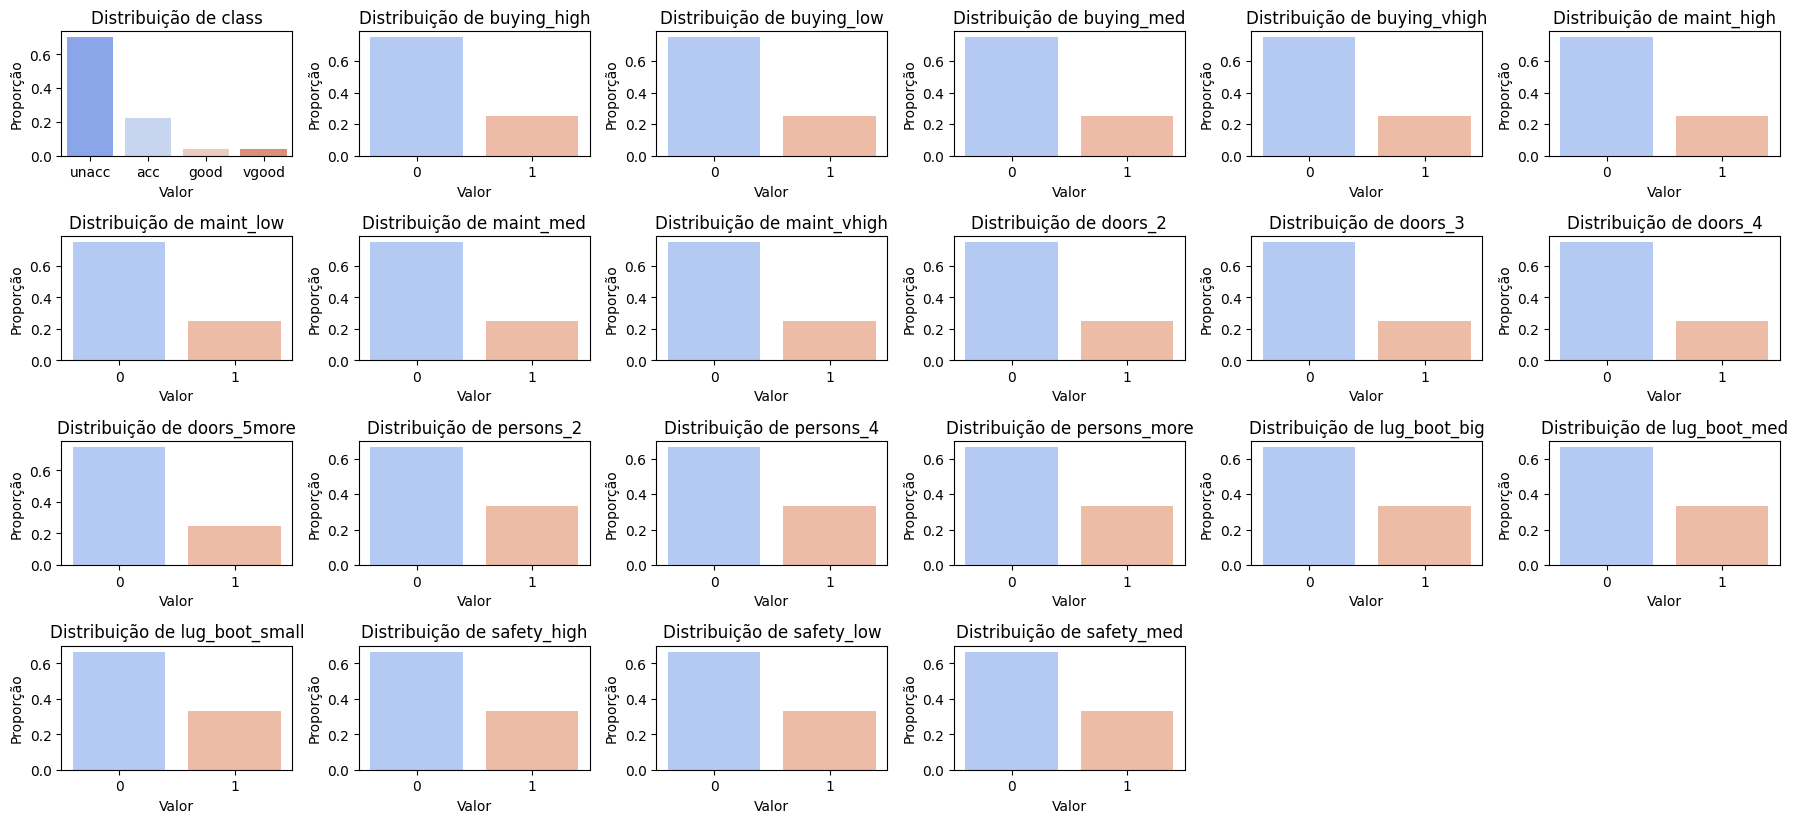

In [19]:
# Verificando a distribuição de valores 0 e 1
for column in df_encoded.columns:
    print(f"{column}:\n{df_encoded[column].value_counts(normalize=True)}\n")

print("\n")

# Criando uma figura e configurando o tamanho
plt.figure(figsize=(18, 12))

# Iterando sobre as colunas de df_encoded e plotando a distribuição de valores (0 e 1)
for i, column in enumerate(df_encoded.columns):
    # Calculando a distribuição de 0s e 1s para cada coluna
    value_counts = df_encoded[column].value_counts(normalize=True)
    
    # Criando um gráfico de barras para cada coluna
    plt.subplot(6, 6, i+1)  # Ajuste o número de linhas e colunas conforme o tamanho da matriz
    sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette='coolwarm', legend=False)
    
    # Definindo título e labels para cada gráfico de barras
    plt.title(f'Distribuição de {column}')
    plt.xlabel('Valor')
    plt.ylabel('Proporção')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()

#### Oversampling

In [20]:
# Separando características e classes
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# Aplicando SMOTE para aumentar a classe minoritária
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Mostra a nova distribuição das classes
print(y_resampled.value_counts())

class
unacc    1210
acc      1210
vgood    1210
good     1210
Name: count, dtype: int64


#### Undersampling

In [21]:
# Aplicando RandomUnderSampler para reduzir a classe majoritária
undersample = RandomUnderSampler(random_state=42)
X_under, y_under = undersample.fit_resample(X, y)

# Mostra a nova distribuição das classes
print(y_under.value_counts())

class
acc      65
good     65
unacc    65
vgood    65
Name: count, dtype: int64


#### Remoção de Outliers após oversampling e undersampling

In [22]:
# Remoção de outliers com base em limite de 80% dos dados
threshold_resampled = 0.8 * len(X_resampled)
threshold_under = 0.8 * len(X_under)

# Seleciona apenas as colunas numéricas para a soma
numeric_columns_resampled = X_resampled.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns_under = X_under.select_dtypes(include=[np.number]).columns.tolist()

# Cria uma série booleana indicando quais colunas têm soma menor ou igual ao threshold
valid_columns_resampled = (X_resampled[numeric_columns_resampled].sum() <= threshold_resampled)
valid_columns_under = (X_under[numeric_columns_under].sum() <= threshold_under)

# Filtra o DataFrame para manter apenas as colunas válidas
df_cleaned_resampled = pd.DataFrame(X_resampled.loc[:, valid_columns_resampled[valid_columns_resampled].index])
df_cleaned_resampled['class'] = y_resampled

df_cleaned_under = pd.DataFrame(X_under.loc[:, valid_columns_under[valid_columns_under].index])
df_cleaned_under['class'] = y_under

# Combina os dois datasets limpos em um único DataFrame
df_cleaned = pd.concat([df_cleaned_resampled, df_cleaned_under], ignore_index=True)

# Mostra a forma da nova base de dados
print("\nDimensão:\n", df_cleaned.shape)


Dimensão:
 (5100, 22)


## Visualizando Importâncias dos Atributos Pós-processamento

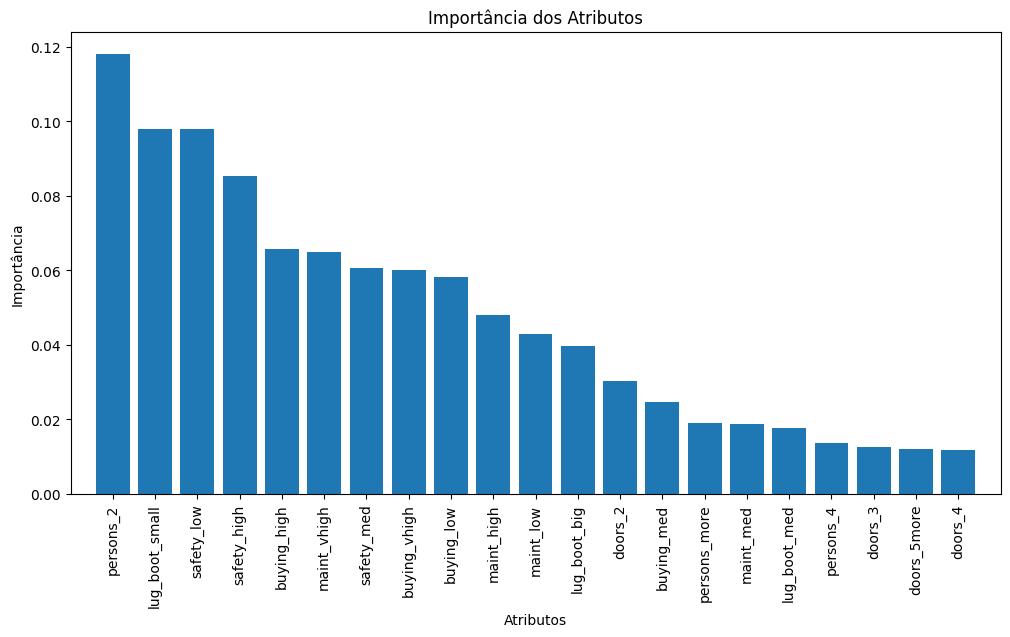

In [23]:
X = df_cleaned.drop('class', axis=1)
y = df_cleaned['class']

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importância dos Atributos")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel("Atributos")
plt.ylabel("Importância")
plt.show()

## Visualizando a distribuição das classes Pós-processamento

class
unacc    1275
acc      1275
vgood    1275
good     1275
Name: count, dtype: int64

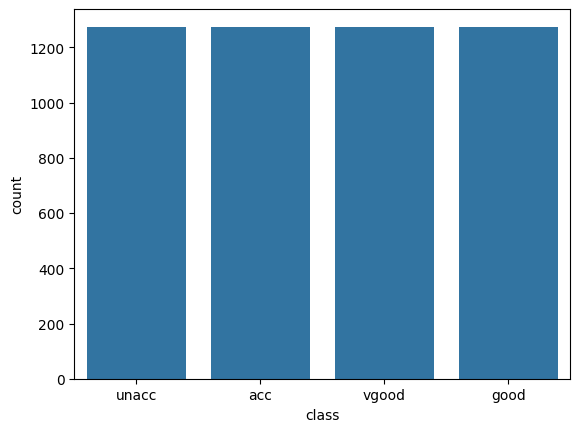

In [24]:
display(df_cleaned['class'].value_counts())

# cria um gráfico de barras com a frequência de cada classe
sns.countplot(x="class", data=df_cleaned)

# mostra o gráfico
plt.show()

## Visualização Final dos Dados

### Histograma

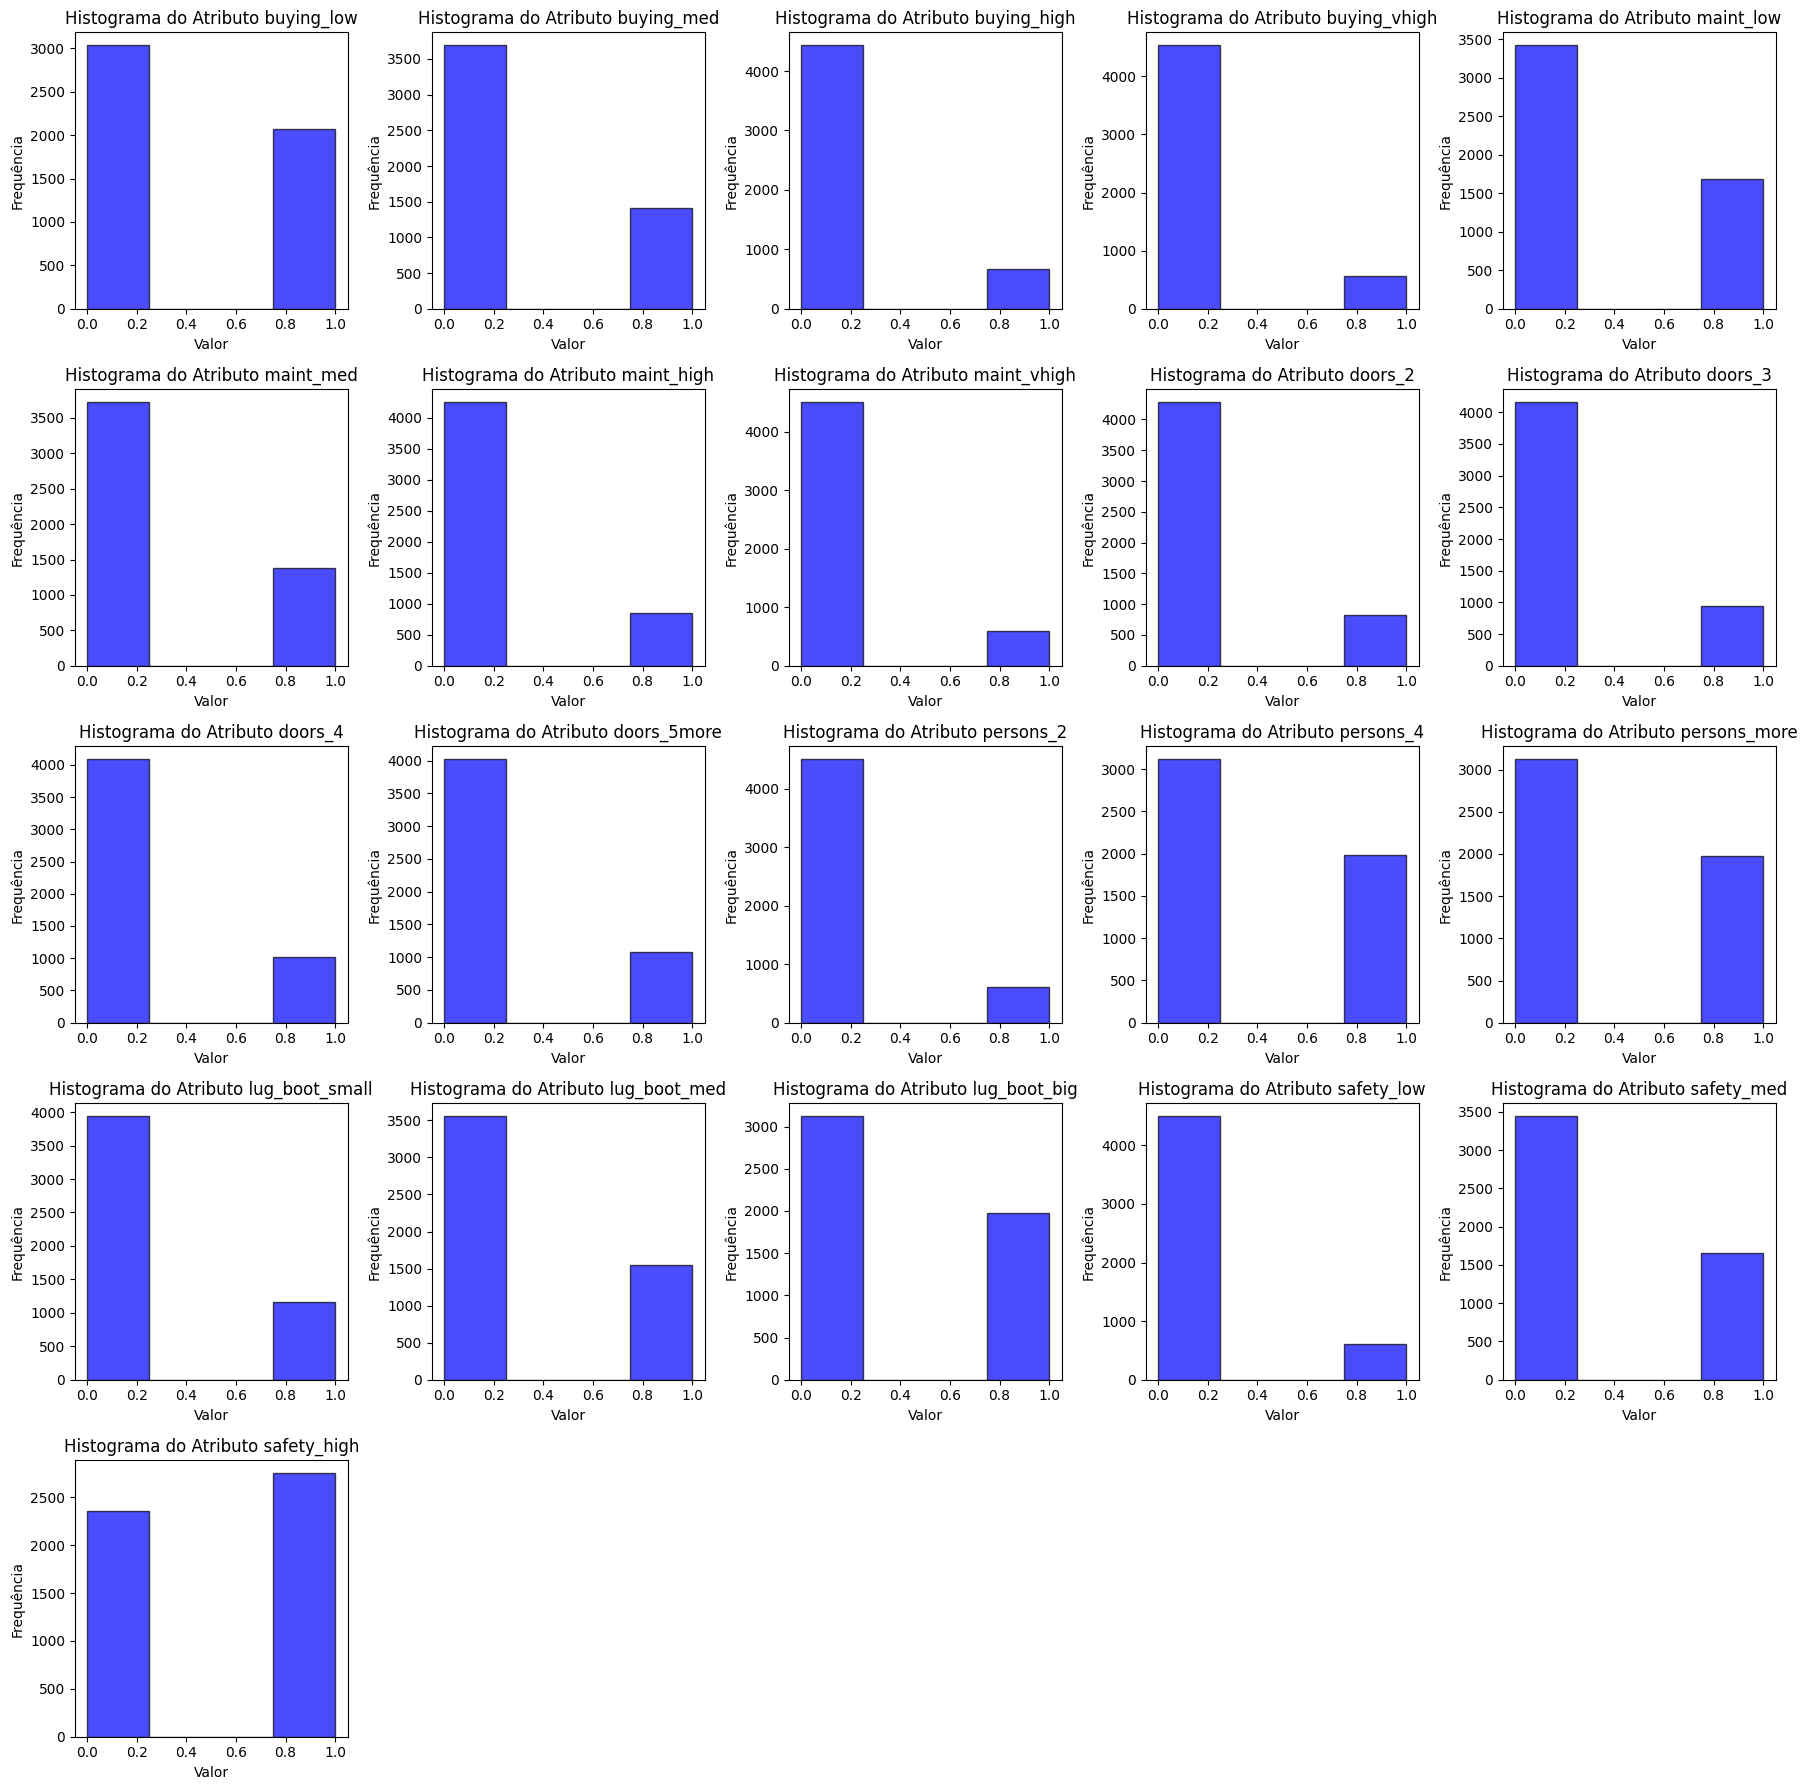

In [25]:
# Selecionando os atributos para visualização
attributes = [
    'buying_low', 'buying_med', 'buying_high', 'buying_vhigh',
    'maint_low', 'maint_med', 'maint_high', 'maint_vhigh',
    'doors_2', 'doors_3', 'doors_4', 'doors_5more',
    'persons_2', 'persons_4', 'persons_more',
    'lug_boot_small', 'lug_boot_med', 'lug_boot_big',
    'safety_low', 'safety_med', 'safety_high'
]

# Configurando o tamanho da figura
plt.figure(figsize=(18, 18))

# Loop para criar histogramas para cada atributo
for i, attr in enumerate(attributes, start=1):
    plt.subplot(5, 5, i)  # Organiza os subgráficos em uma grade
    plt.hist(df_cleaned[attr], bins=4, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histograma do Atributo {attr}')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')

plt.tight_layout()  # Ajusta os subgráficos para evitar sobreposição
plt.show()

### Matriz de Dispersão

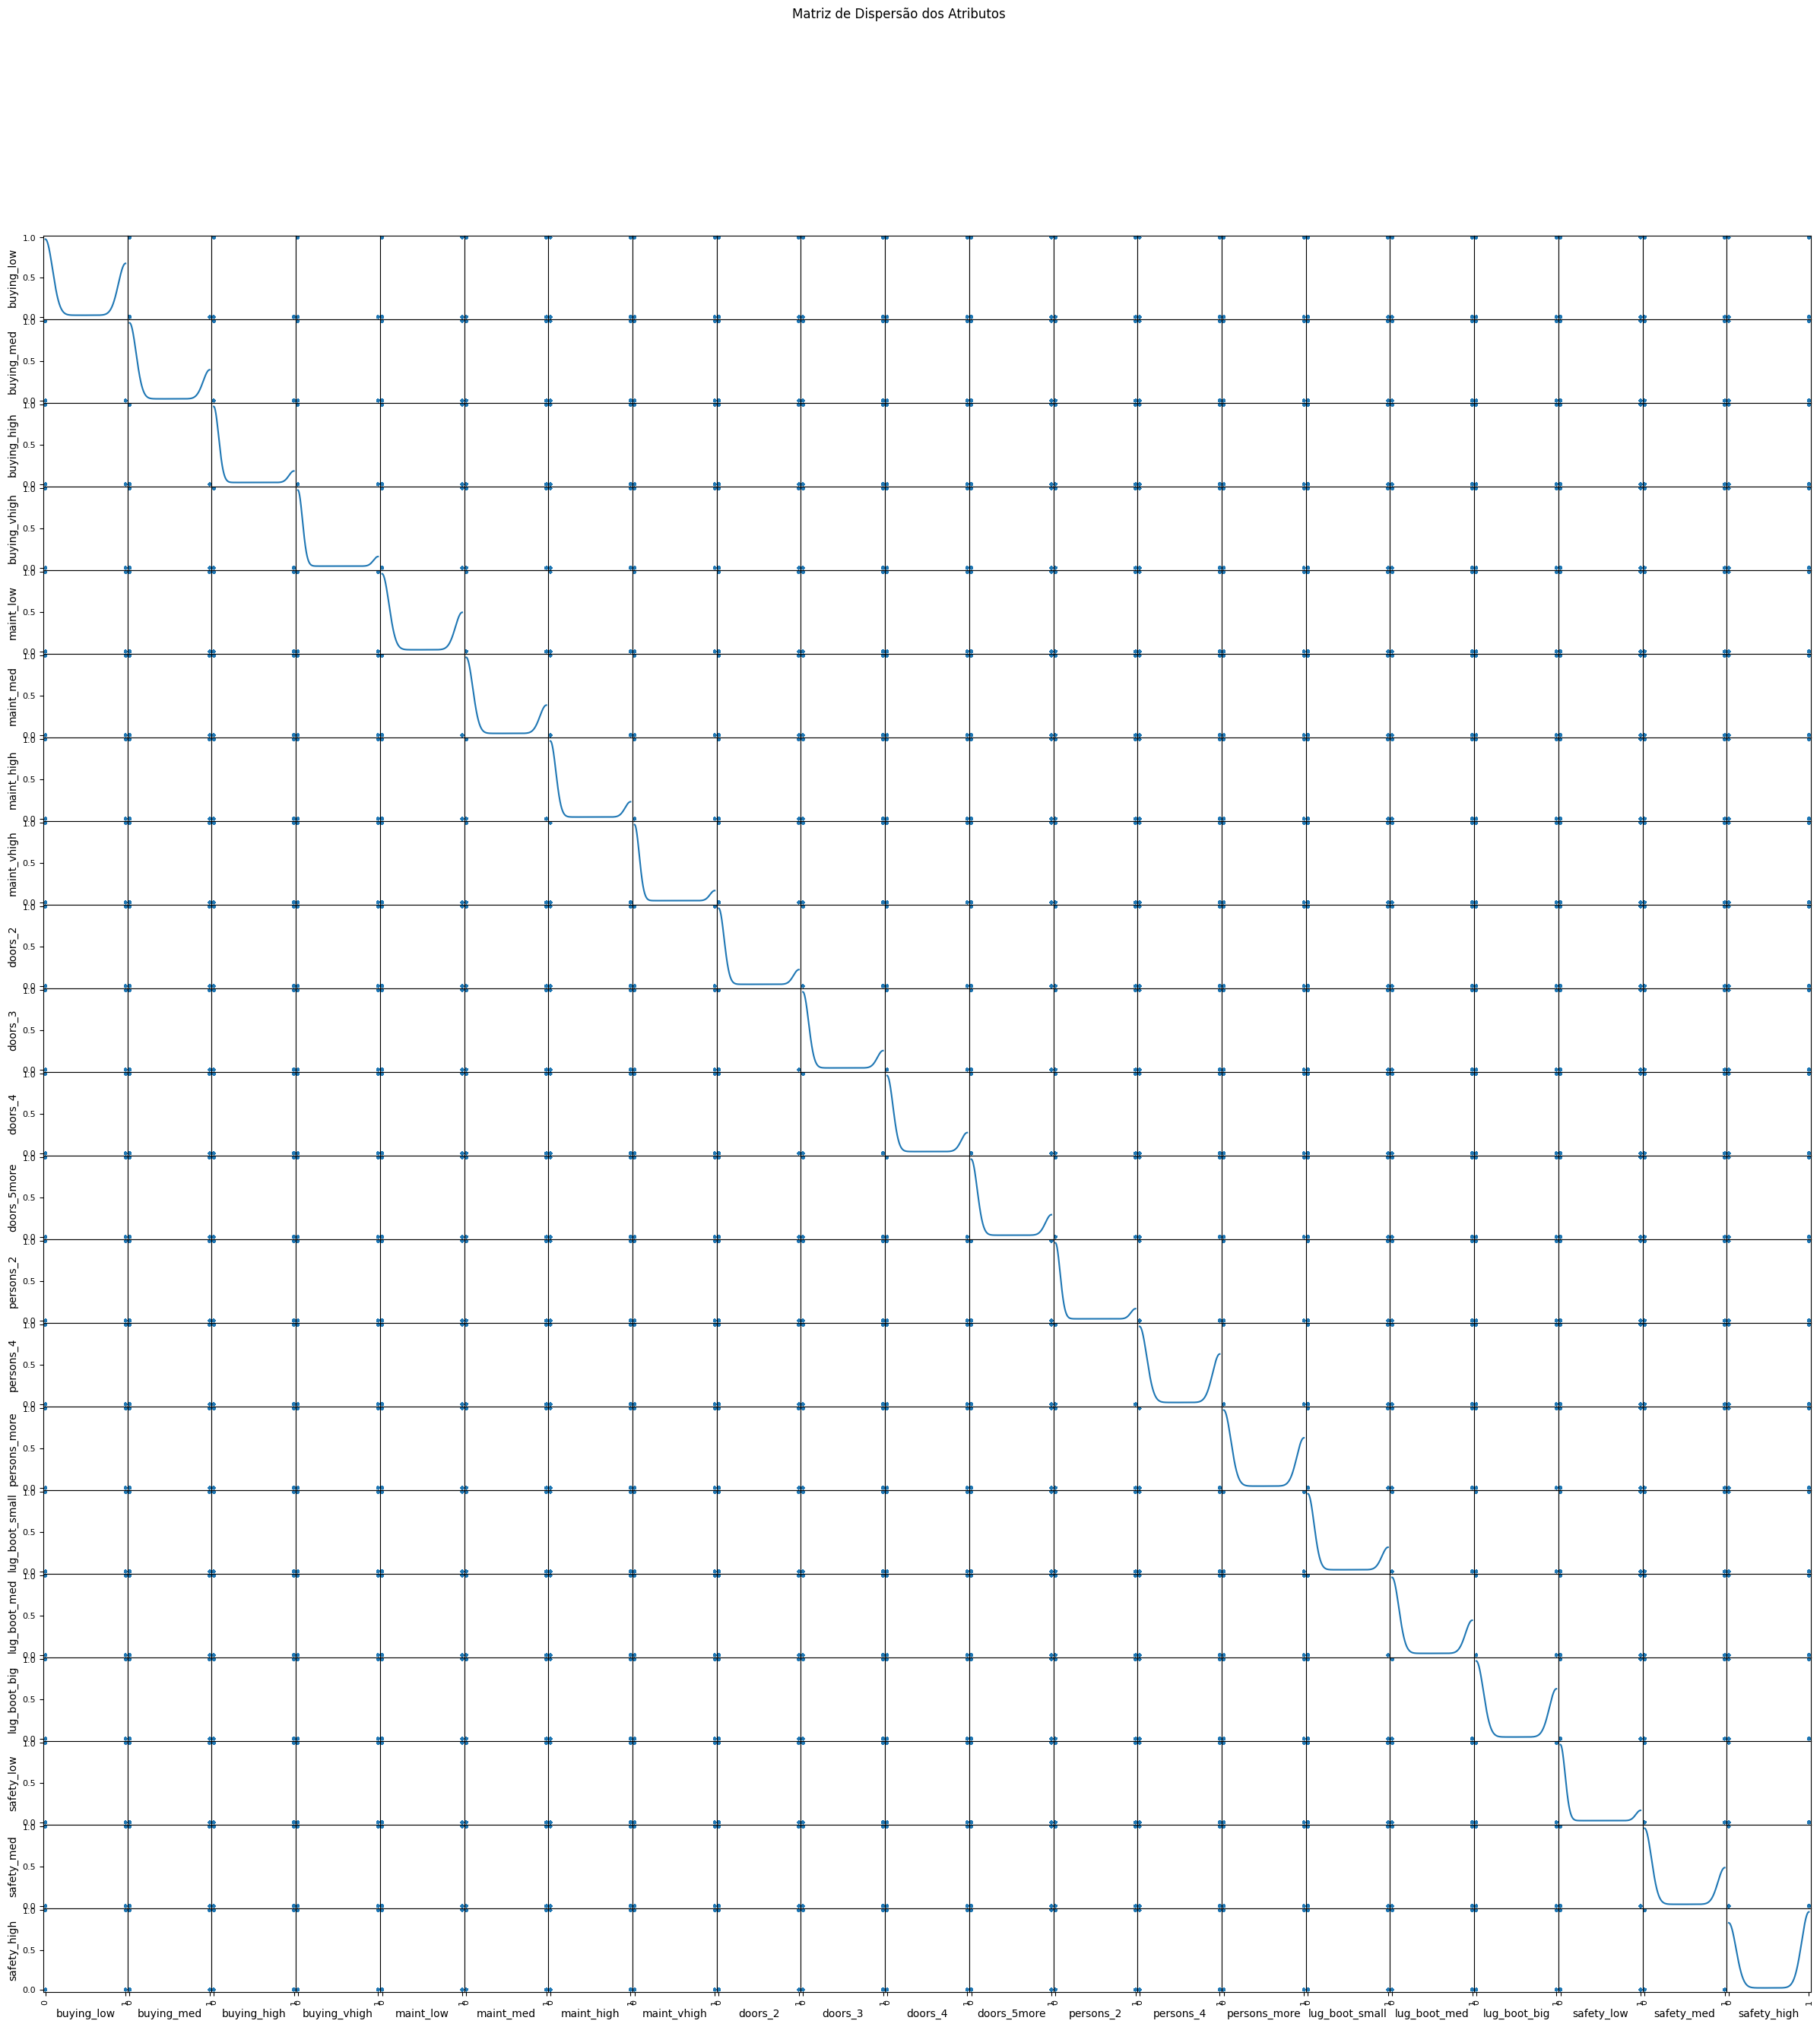

In [26]:
# Selecionando os atributos para a matriz de dispersão
attributes = [
    'buying_low', 'buying_med', 'buying_high', 'buying_vhigh',
    'maint_low', 'maint_med', 'maint_high', 'maint_vhigh',
    'doors_2', 'doors_3', 'doors_4', 'doors_5more',
    'persons_2', 'persons_4', 'persons_more',
    'lug_boot_small', 'lug_boot_med', 'lug_boot_big',
    'safety_low', 'safety_med', 'safety_high'
]

# Criando a matriz de dispersão
scatter_matrix(df_cleaned[attributes], figsize=(30, 30), diagonal='kde', alpha=0.5)

plt.suptitle('Matriz de Dispersão dos Atributos')
plt.show()

### Matriz de Correlação

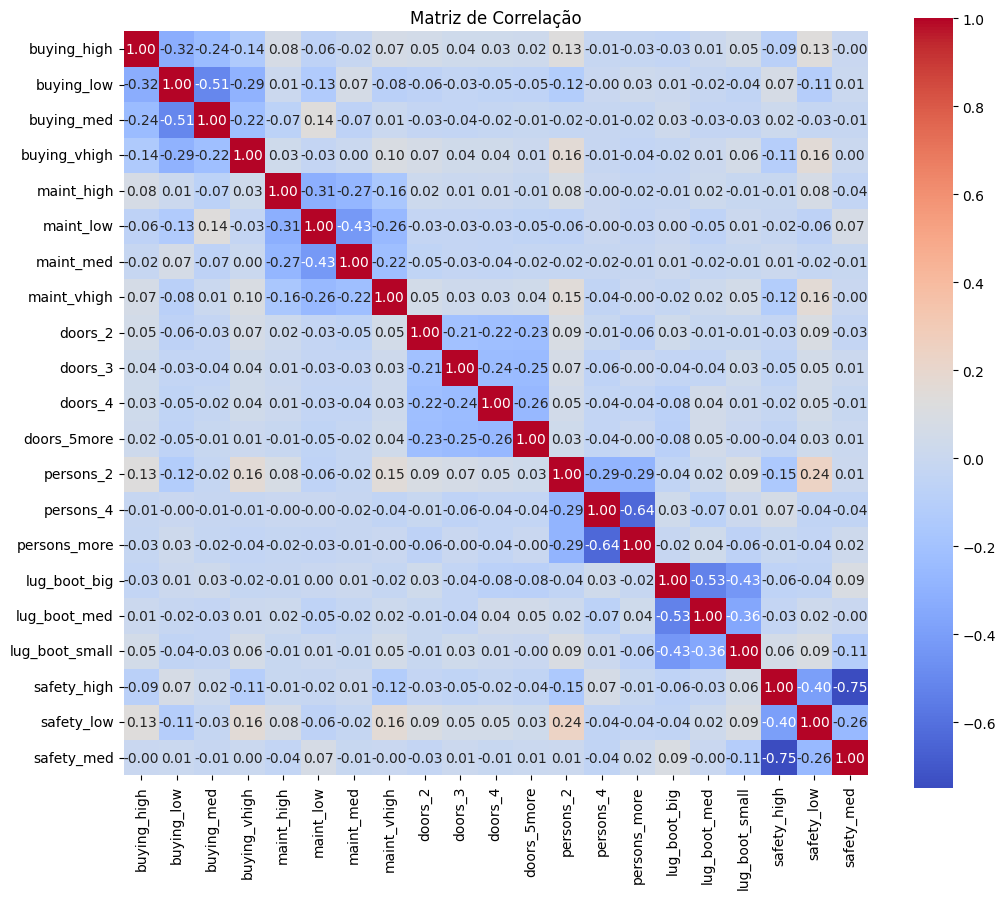

In [27]:
# Filtrando colunas numéricas
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Calcular a matriz de correlação
correlation_matrix = df_cleaned[numeric_columns].corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlação')
plt.show()

> [!NOTE]
> Após o processamento dos dados, podemos eleger um algoritmo para a aprendizagem de nossa máquina.

## Treinamento

### Separando dados para o treinamento

In [28]:
# Separando características e classes
X = df_cleaned.drop('class', axis=1)
y = df_cleaned['class'].astype(str)

# Dividindo os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Definindo modelos de algorimos

In [35]:
models = []

# Regressão Logística (LR)
models.append(('LR', OneVsRestClassifier(LogisticRegression(solver='liblinear'))))

# Análise Linear Discriminante (LDA)
models.append(('LDA', LinearDiscriminantAnalysis()))

# K-vizinhos mais próximos (KNN)
models.append(('KNN', KNeighborsClassifier()))

# Árvores de Classificação (Decision Tree) e Regressão (CART)
models.append(('CART', DecisionTreeClassifier()))

# Gaussian Naive Bayes (NB)
models.append(('NB', GaussianNB()))

# Support Vector Machines (SVM)
models.append(('SVM', SVC(gamma='auto')))

# Multilayer Perceptron MLP
models.append(('MLP', MLPClassifier(hidden_layer_sizes=(13, 9), learning_rate_init=0.09, max_iter=500, random_state=42)))

### Treinando e avaliando todos os modelos

Treinando e avaliando o modelo: LR
Acurácia do modelo LR: 0.8912
Relatório de classificação do modelo LR:
              precision    recall  f1-score   support

         acc       0.81      0.78      0.79       249
        good       0.87      0.96      0.91       238
       unacc       0.99      0.83      0.90       269
       vgood       0.90      1.00      0.95       264

    accuracy                           0.89      1020
   macro avg       0.89      0.89      0.89      1020
weighted avg       0.90      0.89      0.89      1020



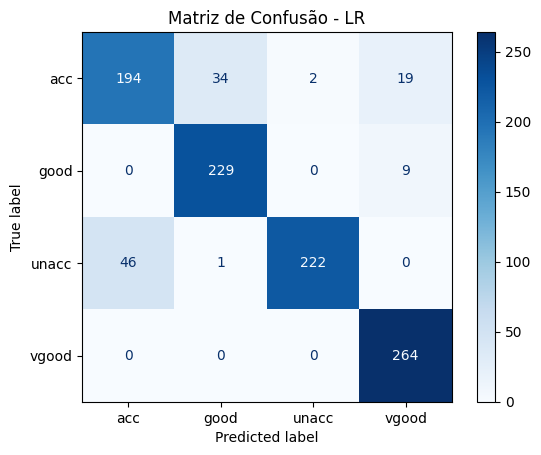

----------------------------------------------------------------------
Treinando e avaliando o modelo: LDA
Acurácia do modelo LDA: 0.8725
Relatório de classificação do modelo LDA:
              precision    recall  f1-score   support

         acc       0.76      0.79      0.77       249
        good       0.85      0.88      0.86       238
       unacc       1.00      0.84      0.92       269
       vgood       0.89      0.97      0.93       264

    accuracy                           0.87      1020
   macro avg       0.88      0.87      0.87      1020
weighted avg       0.88      0.87      0.87      1020



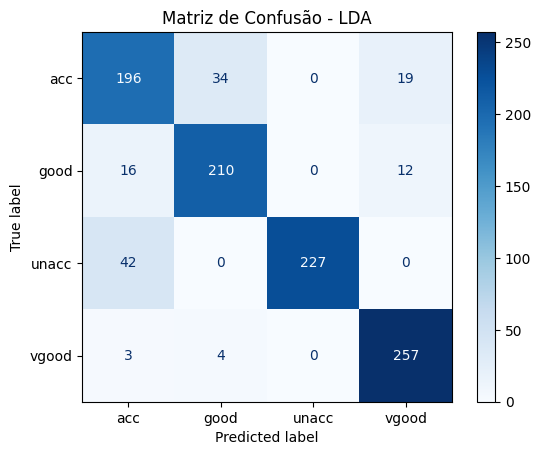

----------------------------------------------------------------------
Treinando e avaliando o modelo: KNN
Acurácia do modelo KNN: 0.9255
Relatório de classificação do modelo KNN:
              precision    recall  f1-score   support

         acc       0.88      0.88      0.88       249
        good       0.90      0.97      0.93       238
       unacc       1.00      0.87      0.93       269
       vgood       0.93      0.99      0.96       264

    accuracy                           0.93      1020
   macro avg       0.93      0.93      0.92      1020
weighted avg       0.93      0.93      0.93      1020



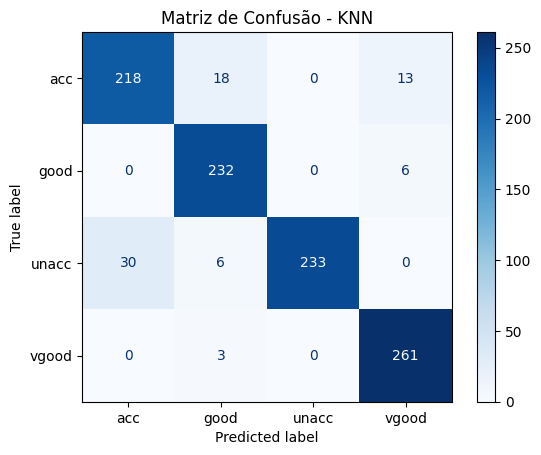

----------------------------------------------------------------------
Treinando e avaliando o modelo: CART
Acurácia do modelo CART: 0.9775
Relatório de classificação do modelo CART:
              precision    recall  f1-score   support

         acc       0.99      0.94      0.97       249
        good       0.97      0.97      0.97       238
       unacc       0.99      1.00      1.00       269
       vgood       0.96      0.99      0.98       264

    accuracy                           0.98      1020
   macro avg       0.98      0.98      0.98      1020
weighted avg       0.98      0.98      0.98      1020



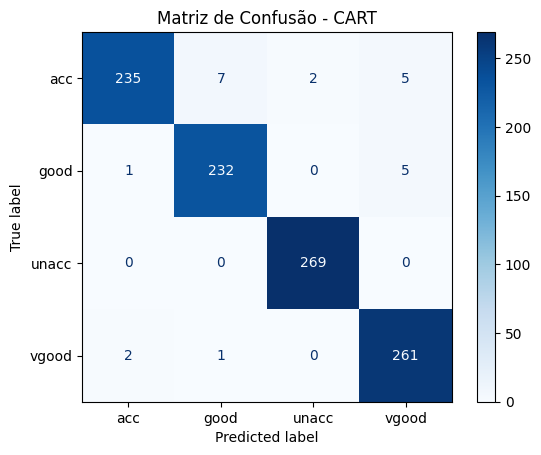

----------------------------------------------------------------------
Treinando e avaliando o modelo: NB
Acurácia do modelo NB: 0.8333
Relatório de classificação do modelo NB:
              precision    recall  f1-score   support

         acc       0.74      0.69      0.71       249
        good       0.79      0.87      0.82       238
       unacc       1.00      0.78      0.87       269
       vgood       0.83      1.00      0.91       264

    accuracy                           0.83      1020
   macro avg       0.84      0.83      0.83      1020
weighted avg       0.84      0.83      0.83      1020



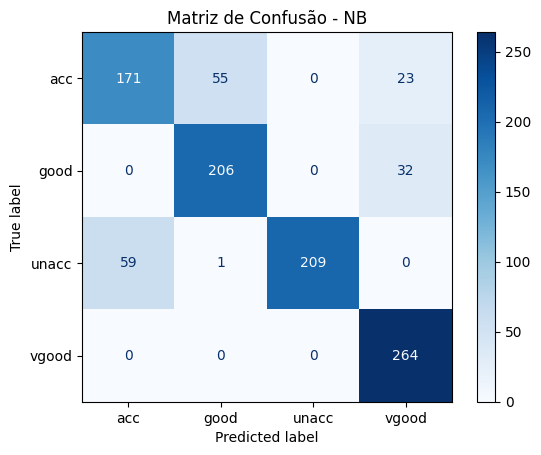

----------------------------------------------------------------------
Treinando e avaliando o modelo: SVM
Acurácia do modelo SVM: 0.9216
Relatório de classificação do modelo SVM:
              precision    recall  f1-score   support

         acc       0.87      0.86      0.86       249
        good       0.91      0.95      0.93       238
       unacc       1.00      0.88      0.93       269
       vgood       0.91      1.00      0.95       264

    accuracy                           0.92      1020
   macro avg       0.92      0.92      0.92      1020
weighted avg       0.92      0.92      0.92      1020



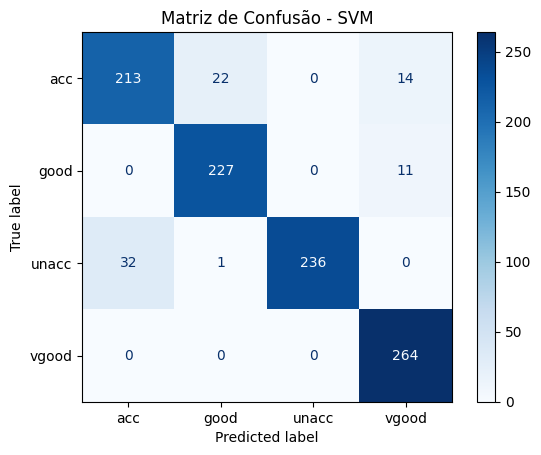

----------------------------------------------------------------------
Treinando e avaliando o modelo: MLP
Acurácia do modelo MLP: 0.9804
Relatório de classificação do modelo MLP:
              precision    recall  f1-score   support

         acc       1.00      0.95      0.98       249
        good       0.98      0.97      0.97       238
       unacc       0.99      1.00      1.00       269
       vgood       0.95      1.00      0.98       264

    accuracy                           0.98      1020
   macro avg       0.98      0.98      0.98      1020
weighted avg       0.98      0.98      0.98      1020



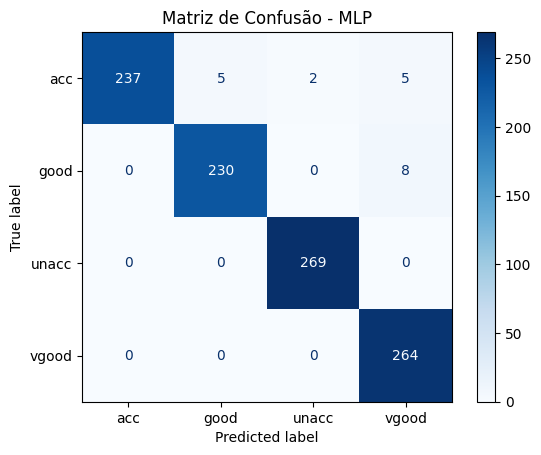

----------------------------------------------------------------------


In [45]:
def comparar_modelos(X_train, X_test, y_train, y_test, models):
    resultados = []  # Lista para armazenar o nome e a acurácia dos modelos
    
    for name, model in models:
        print(f"Treinando e avaliando o modelo: {name}")
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões
        y_pred = model.predict(X_test)
        
        # Avaliando o modelo com a acurácia
        acuracia = accuracy_score(y_test, y_pred)
        print(f"Acurácia do modelo {name}: {acuracia:.4f}")

        print(f"Relatório de classificação do modelo {name}:\n{classification_report(y_test, y_pred)}")
        
        # Calculando a matriz de confusão
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        
        # Exibindo a matriz de confusão como um gráfico
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Matriz de Confusão - {name}')
        plt.show()
        
        print("-" * 70)  # Separando os resultados para cada modelo

        # Armazenando o nome do modelo e a acurácia na lista de resultados
        resultados.append((name, acuracia))
    
    # Encontrando o modelo com a maior acurácia
    melhor_modelo = max(resultados, key=lambda x: x[1])
    
    # Retornando o nome e a acurácia do melhor modelo
    return melhor_modelo

melhor_modelo = comparar_modelos(X_train, X_test, y_train, y_test, models)

### Melhor modelo

In [47]:
print(f"\nO melhor modelo é {melhor_modelo[0]} com uma acurácia de {melhor_modelo[1]:.4f}")


O melhor modelo é MLP com uma acurácia de 0.9804


Para salvar o modelo treinado e utilizá-lo futuramente para as previsões da aplicação, utilizamos o seguinte código:

```python
import joblib


# Salvando o modelo para uso futuro
joblib.dump(model, 'mlp_model.pkl')
print('Model saved as mlp_model.pkl')
```